In [8]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer,  DataCollatorWithPadding
from transformers import get_scheduler
import torch
from datasets import Dataset, DatasetDict
import pandas as pd
import os
import re
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import DataLoader, RandomSampler
from torch.nn.utils.rnn import pad_sequence

# new file
from rules_polypersonal_combo import preprocess_texts


In [9]:
# Define the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("Llamacha/QuBERTa")
model = AutoModelForSequenceClassification.from_pretrained("Llamacha/QuBERTa", num_labels=27)  # adjust num_labels as necessary

Some weights of the model checkpoint at Llamacha/QuBERTa were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at Llamacha/QuBERTa and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You s

In [10]:
def split_document(text, max_length=250, overlap=50):
    # Split text into words
    words = text.split()
    parts = []
    if len(words) <= max_length:
        return [text]  # Return the entire text if it's short enough

    i = 0
    while i < len(words):
        # Ensure that we don't exceed the text length
        end_index = min(i + max_length, len(words))
        # Join the selected range of words back into a string
        chunk_text = " ".join(words[i:end_index])
        parts.append(chunk_text)
        i += (max_length - overlap)
    
    return parts

In [11]:
def remove_numbers(text):
    # Remove numbers using regular expression
    text_without_numbers = re.sub(r'\d+', '', text)
    return text_without_numbers


In [12]:
def load_and_preprocess(directory_paths):
    processed_data = []
    label_dict = {dialect: idx for idx, dialect in enumerate(directory_paths.keys())}
    
    for dialect, directory_path in directory_paths.items():
        print("dialect:", dialect)
        for filename in os.listdir(directory_path):
            if filename.endswith('.txt'):
                print("filename:", filename)
                file_path = os.path.join(directory_path, filename)
                
                with open(file_path, 'r', encoding='latin-1') as file:
                    text = file.read().strip()
                    text = remove_numbers(text)
                    
                    # Split the original text into chunks
                    chunks = split_document(text)
                    print("document is in", len(chunks), "chunks")
                    
                    # Process each chunk without any tags
                    for chunk in chunks:
                        encoded_text = tokenizer(
                            chunk,
                            truncation=True,
                            padding='max_length',
                            max_length=512,
                            return_tensors="pt"
                        )
                        input_ids_list = encoded_text['input_ids'].squeeze(0).tolist()
                        attention_mask_list = encoded_text['attention_mask'].squeeze(0).tolist()
                        
                        processed_data.append({
                            'input_ids': input_ids_list,
                            'attention_mask': attention_mask_list,
                            'labels': label_dict[dialect]
                        })
                        
    return processed_data


In [13]:
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_masks = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]
    
    input_ids = pad_sequence([torch.tensor(seq) for seq in input_ids], batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks = pad_sequence([torch.tensor(mask) for mask in attention_masks], batch_first=True, padding_value=0)
    
    labels = torch.tensor(labels)
    
    return {'input_ids': input_ids, 'attention_mask': attention_masks, 'labels': labels}


In [14]:

# no bible data, only other and augmented data
directory_paths = {
    'inb': '../language_resources/no_bible_all_data_jan2025/inb',
    'qub': '../language_resources/no_bible_all_data_jan2025/qub',
    'quh': '../language_resources/no_bible_all_data_jan2025/quh',
    'quk': '../language_resources/no_bible_all_data_jan2025/quk',
    'qux': '../language_resources/no_bible_all_data_jan2025/qux',
    'quy': '../language_resources/no_bible_all_data_jan2025/quy',
    'quz': '../language_resources/no_bible_all_data_jan2025/quz', 
    'qwh': '../language_resources/no_bible_all_data_jan2025/qwh',
    'qxo': '../language_resources/no_bible_all_data_jan2025/qxo'
}


# go through loading & processing
processed_data = load_and_preprocess(directory_paths)

dialect: inb
filename: Sibundoy-Verbal-Art.txt
document is in 1 chunks
filename: Sibudoy-Verbal-Art2.txt
document is in 3 chunks
dialect: qub
filename: hual_sag1.txt
document is in 9 chunks
filename: hual_pqescq.txt
document is in 9 chunks
dialect: quh
filename: MUL028R071I001.txt
document is in 6 chunks
filename: MUL028R109I001.txt
document is in 6 chunks
filename: MUL028R061I001.txt
document is in 6 chunks
filename: MUL028R095I001.txt
document is in 6 chunks
filename: MUL028R085I001.txt
document is in 10 chunks
filename: ailla_story_bolivian.txt
document is in 52 chunks
filename: MUL028R068I001.txt
document is in 6 chunks
filename: MUL028R110I001.txt
document is in 6 chunks
filename: MUL028R078I001.txt
document is in 4 chunks
filename: MUL028R100I001.txt
document is in 6 chunks
filename: MUL028R101I001.txt
document is in 6 chunks
filename: MUL028R079I001.txt
document is in 6 chunks
filename: MUL028R069I001.txt
document is in 6 chunks
filename: interview_rufina1.txt
document is in 43 

In [15]:

# Create the dataset directly from a dictionary
dataset = Dataset.from_dict({'input_ids': [x['input_ids'] for x in processed_data],
                             'attention_mask': [x['attention_mask'] for x in processed_data],
                             'labels': [x['labels'] for x in processed_data]})
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
split_datasets = dataset.train_test_split(test_size=0.15)
train_dataset = split_datasets['train']
val_dataset = split_datasets['test']

train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=8, collate_fn=collate_fn, sampler=train_sampler)



In [16]:
# List to store accuracy per epoch
epoch_accuracy = []

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    epoch_accuracy.append(acc)  # Store accuracy
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


In [17]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,  # Increased epochs
    # per_device_train_batch_size=10,  # Slightly larger batch size - original
    per_device_train_batch_size=20,  # Slightly larger batch size
    per_device_eval_batch_size=15,
    warmup_steps=500,  # Adjusted warmup steps
    weight_decay=0.01,  # Adjusted weight decay
    # learning_rate=5e-5,  # Added explicit learning rate
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    lr_scheduler_type='cosine',  # Using a cosine learning rate scheduler
    save_strategy="epoch",  # Save the model at each epoch
    load_best_model_at_end=True,  # Load the best model at the end of training
    metric_for_best_model="accuracy"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [18]:
trainer.train()

/Users/clairepost/opt/anaconda3/envs/nlp_hw/lib/python3.11/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 13721
  Num Epochs = 1
  Instantaneous batch size per device = 20
  Total train batch size (w. parallel, distributed & accumulation) = 20
  Gradient Accumulation steps = 1
  Total optimization steps = 687
  Number of trainable parameters = 83471643


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/687 [00:00<?, ?it/s]

{'loss': 3.2784, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01}
{'loss': 3.099, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.03}
{'loss': 2.674, 'learning_rate': 3e-06, 'epoch': 0.04}
{'loss': 2.1177, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.06}
{'loss': 1.6498, 'learning_rate': 5e-06, 'epoch': 0.07}
{'loss': 1.2656, 'learning_rate': 6e-06, 'epoch': 0.09}
{'loss': 1.136, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.1}
{'loss': 0.9856, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.12}
{'loss': 0.8187, 'learning_rate': 9e-06, 'epoch': 0.13}
{'loss': 0.8113, 'learning_rate': 1e-05, 'epoch': 0.15}
{'loss': 0.562, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.16}
{'loss': 0.4997, 'learning_rate': 1.2e-05, 'epoch': 0.17}
{'loss': 0.5492, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.19}
{'loss': 0.5702, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.2}
{'loss': 0.42, 'learning_rate': 1.5e-05, 'epoch': 0.22}
{'loss': 0.3983, 'learning_rate

***** Running Evaluation *****
  Num examples = 2422
  Batch size = 15


  0%|          | 0/162 [00:00<?, ?it/s]

/Users/clairepost/opt/anaconda3/envs/nlp_hw/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Saving model checkpoint to ./results/checkpoint-687
Configuration saved in ./results/checkpoint-687/config.json


{'eval_loss': 0.121308833360672, 'eval_accuracy': 0.967795210569777, 'eval_f1': 0.964813566105315, 'eval_precision': 0.9625821552944623, 'eval_recall': 0.967795210569777, 'eval_runtime': 202.3869, 'eval_samples_per_second': 11.967, 'eval_steps_per_second': 0.8, 'epoch': 1.0}


Model weights saved in ./results/checkpoint-687/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./results/checkpoint-687 (score: 0.967795210569777).


{'train_runtime': 5908.9317, 'train_samples_per_second': 2.322, 'train_steps_per_second': 0.116, 'train_loss': 0.45445202716139554, 'epoch': 1.0}


TrainOutput(global_step=687, training_loss=0.45445202716139554, metrics={'train_runtime': 5908.9317, 'train_samples_per_second': 2.322, 'train_steps_per_second': 0.116, 'train_loss': 0.45445202716139554, 'epoch': 1.0})

Train the model then save the model path so it can be used for unclassified data

In [19]:
model_path = './models/neural_rules_3'
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

Configuration saved in ./models/neural_rules_3/config.json
Model weights saved in ./models/neural_rules_3/pytorch_model.bin
tokenizer config file saved in ./models/neural_rules_3/tokenizer_config.json
Special tokens file saved in ./models/neural_rules_3/special_tokens_map.json


('./models/neural_rules_3/tokenizer_config.json',
 './models/neural_rules_3/special_tokens_map.json',
 './models/neural_rules_3/vocab.json',
 './models/neural_rules_3/merges.txt',
 './models/neural_rules_3/added_tokens.json',
 './models/neural_rules_3/tokenizer.json')

In [20]:
def get_predictions(model, dataloader):
    model.eval()  # Put model in evaluation mode
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            inputs = {'input_ids': batch['input_ids'].to(model.device),
                      'attention_mask': batch['attention_mask'].to(model.device)}
            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())
    
    return predictions, true_labels


***** Running Prediction *****
  Num examples = 2422
  Batch size = 15


  0%|          | 0/162 [00:00<?, ?it/s]

/Users/clairepost/opt/anaconda3/envs/nlp_hw/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


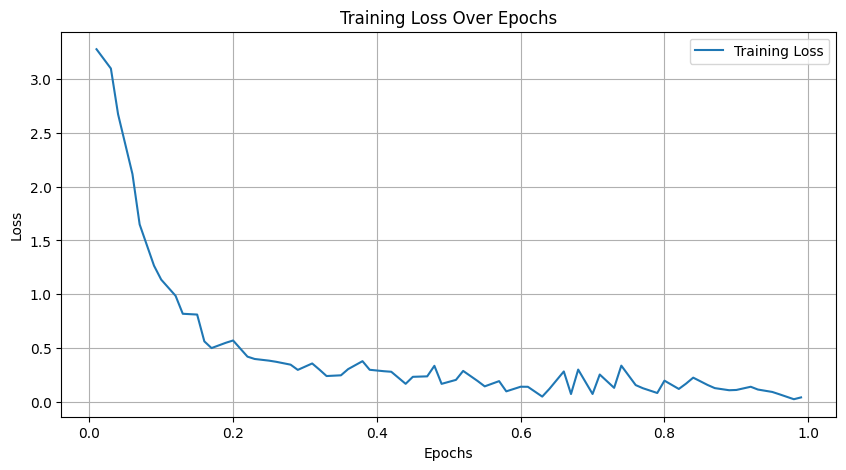

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on the validation set
predictions = trainer.predict(val_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = predictions.label_ids

# Plot training loss
training_loss = trainer.state.log_history

epochs = [x['epoch'] for x in training_loss if 'loss' in x]
loss = [x['loss'] for x in training_loss if 'loss' in x]

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
from sklearn.metrics import classification_report

# Assuming you have a DataLoader for your validation dataset
val_dataloader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn)  # Adjust batch size as needed

# Get predictions
predictions, true_labels = get_predictions(model, val_dataloader)

# Generate classification report
report = classification_report(true_labels, predictions, target_names=[label for label in directory_paths.keys()])
print("Classification Report:\n", report)


/var/folders/fs/xcmh2x8j5zdc3l6qxd_9cy7w0000gn/T/ipykernel_34202/64439305.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = pad_sequence([torch.tensor(seq) for seq in input_ids], batch_first=True, padding_value=tokenizer.pad_token_id)
/var/folders/fs/xcmh2x8j5zdc3l6qxd_9cy7w0000gn/T/ipykernel_34202/64439305.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_masks = pad_sequence([torch.tensor(mask) for mask in attention_masks], batch_first=True, padding_value=0)


Classification Report:
               precision    recall  f1-score   support

         inb       0.00      0.00      0.00         2
         qub       0.00      0.00      0.00         4
         quh       0.83      0.95      0.88       161
         quk       0.00      0.00      0.00         5
         qux       0.89      0.93      0.91       175
         quy       0.98      0.98      0.98       389
         quz       0.99      0.98      0.99      1664
         qwh       0.85      0.69      0.76        16
         qxo       0.00      0.00      0.00         6

    accuracy                           0.97      2422
   macro avg       0.50      0.50      0.50      2422
weighted avg       0.96      0.97      0.96      2422



/Users/clairepost/opt/anaconda3/envs/nlp_hw/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/clairepost/opt/anaconda3/envs/nlp_hw/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/clairepost/opt/anaconda3/envs/nlp_hw/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

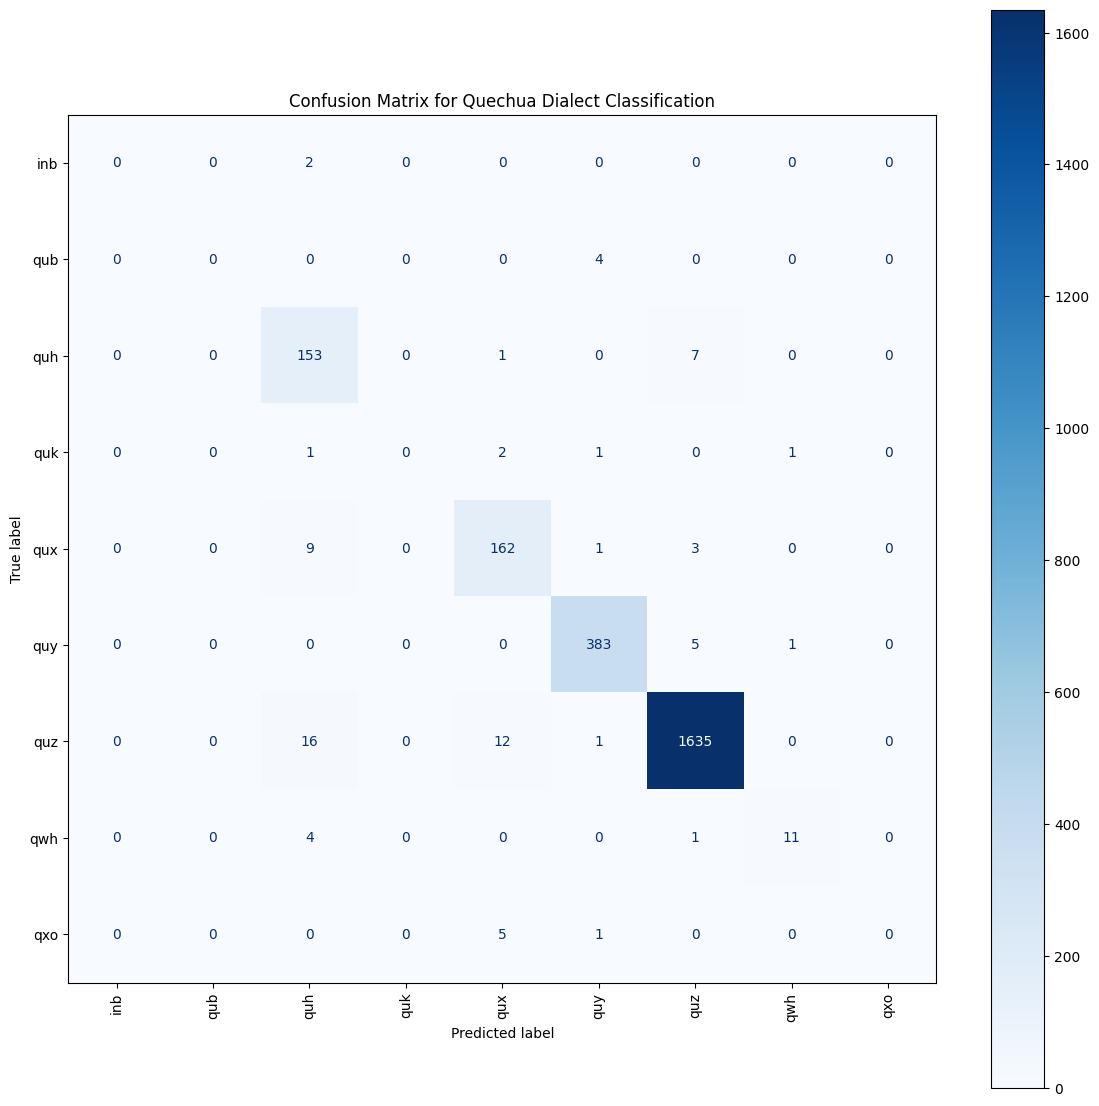

In [23]:
# Extract dialect names from the directory paths
dialect_labels = list(directory_paths.keys())

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
# Create a confusion matrix display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dialect_labels)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(14, 14))  # Adjust size as necessary for readability
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
ax.set_title('Confusion Matrix for Quechua Dialect Classification')
plt.show()

<Figure size 1000x700 with 0 Axes>

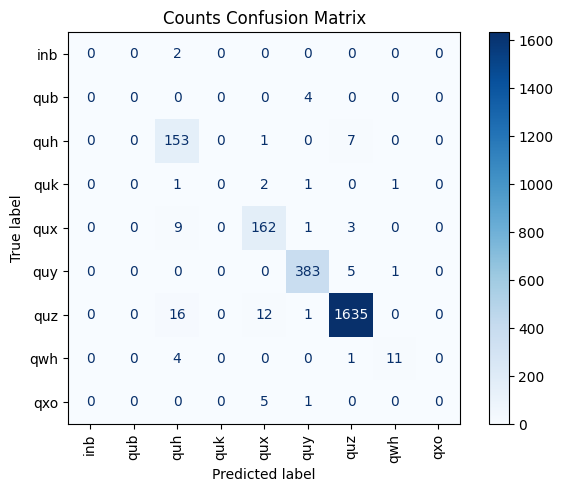

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predictions, labels=list(range(len(directory_paths))))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label for label in directory_paths.keys()])

# Increase figure size
plt.figure(figsize=(10, 7))  # Adjust the size as needed
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90, fontsize=10)  # Rotate labels and adjust font size
plt.yticks(fontsize=10)
plt.tight_layout()  # Adjust layout
plt.title("Counts Confusion Matrix")
plt.show()

Normalized Confusion Matrix

<Figure size 1000x700 with 0 Axes>

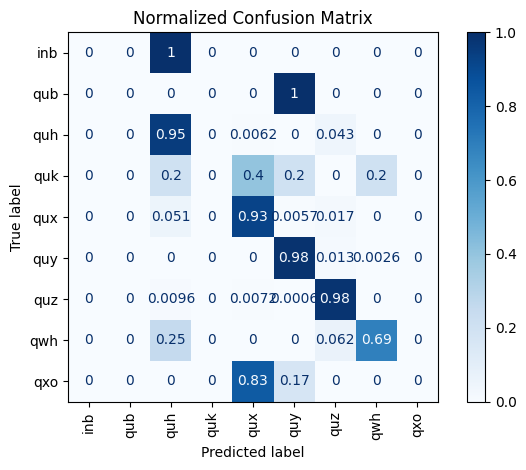

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predictions, labels=list(range(len(directory_paths))), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label for label in directory_paths.keys()])

# Increase figure size
plt.figure(figsize=(10, 7))  # Adjust the size as needed
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90, fontsize=10)  # Rotate labels and adjust font size
plt.yticks(fontsize=10)
plt.title("Normalized Confusion Matrix")
plt.tight_layout()  # Adjust layout
plt.show()

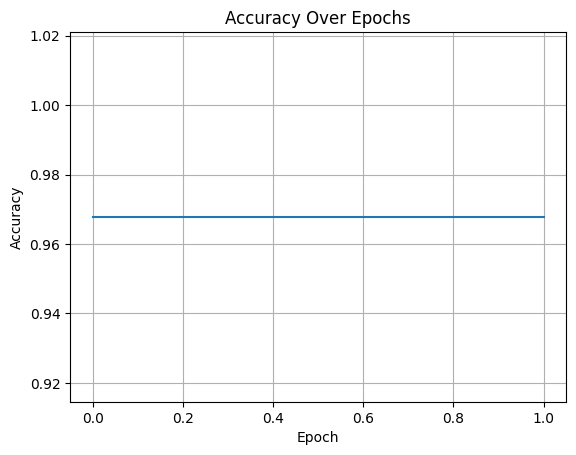

In [26]:
plt.plot(epoch_accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.grid(True)
plt.show()

/Users/clairepost/opt/anaconda3/envs/nlp_hw/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/clairepost/opt/anaconda3/envs/nlp_hw/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/clairepost/opt/anaconda3/envs/nlp_hw/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

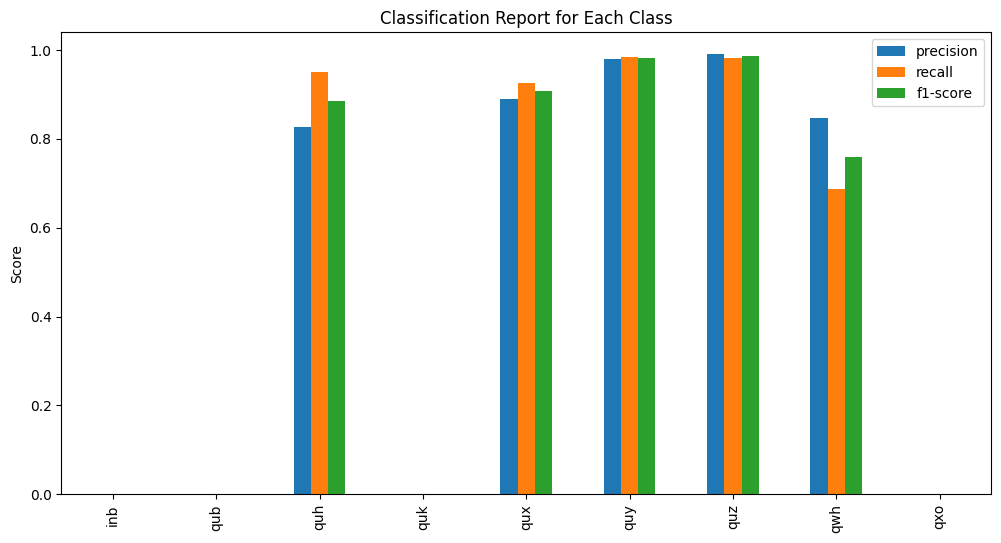

In [27]:
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

report = classification_report(true_labels, predictions, target_names=directory_paths.keys(), output_dict=True)
report_df = pd.DataFrame(report).transpose()

report_df.drop(['accuracy', 'macro avg', 'weighted avg'], inplace=True)  # Drop averages/total
report_df[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(12, 6))
plt.title('Classification Report for Each Class')
plt.ylabel('Score')
plt.show()
